In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import sys
sys.path.append('')

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshLChannel
from optimizer import Annealing, AnnealingSolver, PolyTop

# Topology Optimization for L-Channel Flow

## Computational Mesh

In [2]:
# Create Meshes for L-Channel.
n_elem_for_width = 10
mesh_v = MeshLChannel('Q2', n_elem_for_width)
mesh_p = MeshLChannel('Q1', n_elem_for_width)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model

### Boundary Conditions

In [3]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 0.0; v_y = 4*(1.-x)*(2.-x)  
    return np.array([v_x, v_y])

In [4]:
def outlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = -4*(1.-y)*y; v_y = 0.0 
    return np.array([v_x, v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}

for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'outlet':
            boundary_velocity[boundary].append(outlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))
# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        #if boundary == 'inlet' or boundary == 'outlet' or boundary == 'wall':
        if boundary == 'inlet' or boundary == 'wall':
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # TODO: v_x at the outlet should not be prescribed!
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]]) 
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

# Pressure.
BC = []
for boundary in mesh_p.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_p.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall':
            pass
boundary_values_p= np.array(BC)

### Material Properties

In [ ]:
viscosity = 1.0; 
density = 0.5

### Finite Element Model

In [12]:
fem = FEM(mesh_v, mesh_p, viscosity, density)
fem.set_boudary_values_v(boundary_values_v)

## Classical Optimization

In [7]:
# Settings for Optimization.
volume_fraction_max = 0.75 # Volume fraction.

density_initial = volume_fraction_max*np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

design_tolerance = 0.01 # Convergence tolerance on design variables.
max_iterations = 1 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values = [0.01, 0.1, 1.] #

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.07635620527494852, Volume Fraction: 0.749990120779955


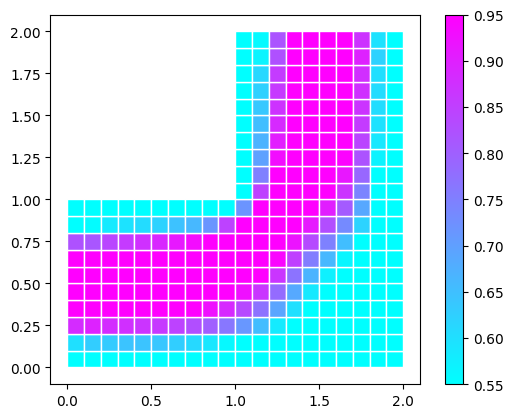

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.19096863073071071, Volume Fraction: 0.7499997789333496


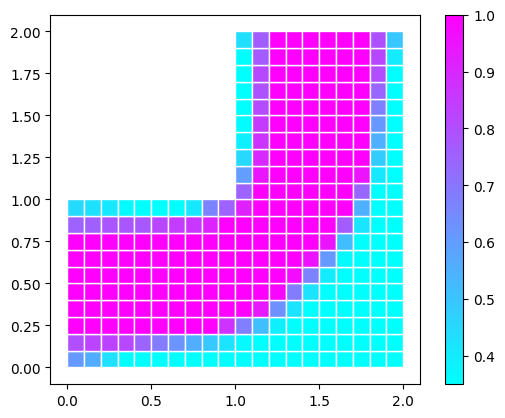

############### q = 1.0 ################
Iteration: 1, Objective Function: 0.0916859188402768, Volume Fraction: 0.7500301974508075


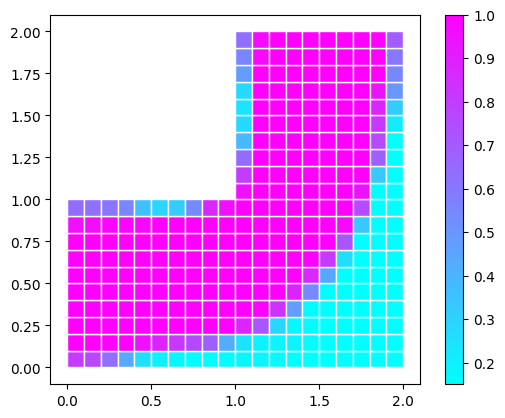

In [8]:
poly_top = PolyTop(fem)
poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                  design_tolerance, max_iterations, q_values,
                  opt_OCMove, opt_OCEta)

## Optimization with Annealing

In [9]:
from amplify.client import FixstarsClient
client = FixstarsClient()
client.parameters.timeout = 500
client.parameters.outputs.duplicate = True
client.token = ''
client.proxy = ''

annealing_solver = AnnealingSolver(client)

Iteration: 0, Objective Function: 0.06579220408114372, Volume Fraction: 0.7803703703703704


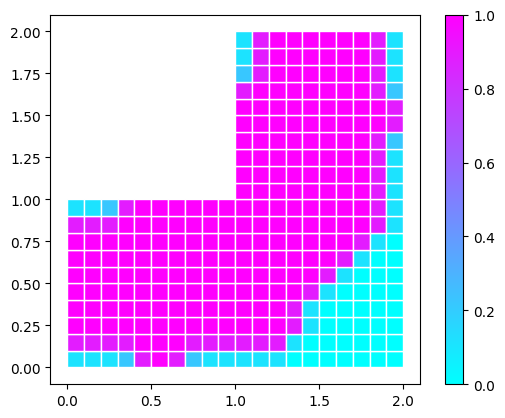

Iteration: 1, Objective Function: 0.052116571997893484, Volume Fraction: 0.7537037037037038


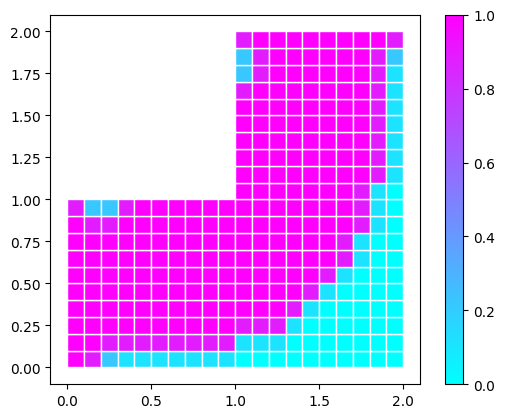

Iteration: 2, Objective Function: 0.045376486526186685, Volume Fraction: 0.75


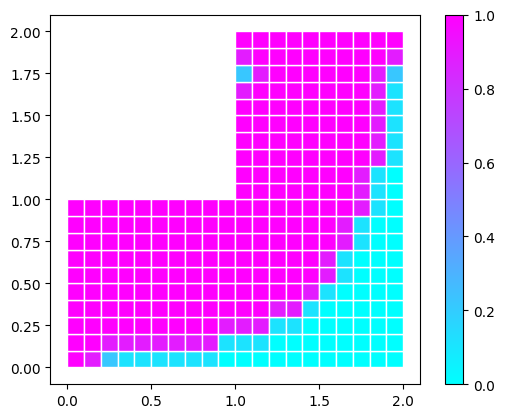

In [10]:
annealing_optimizer = Annealing(fem)
annealing_optimizer.optimize(annealing_solver, 
                             density_initial, density_min, density_max, volume_fraction_max)

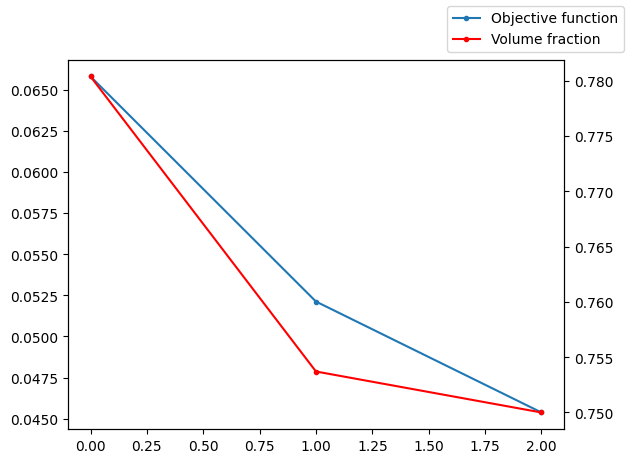

In [11]:
annealing_optimizer.plot_history()